In [12]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [353]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 910, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)

    bms = bmf.reshape(y, x)
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [439]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:int(ibegin + dist)])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [440]:

synclevel = 8900 # np.min(slpfdata[0:910*300])
whitetip = 44230 # np.max(slpfdata[0:910*300])

synclevel = np.min(slpfdata[0:910*300])
whitetip = np.max(slpfdata[0:910*300])

hz_ire_scale = (whitetip - synclevel) / 140

def RawToIRE(data):
    return ((np.float32(data) - synclevel) / hz_ire_scale) - 40

def IREToRaw(data):
    minire = (synclevel / hz_ire_scale) + 40
    return np.uint16((data + minire) * hz_ire_scale)

In [441]:
synclevel, hz_ire_scale, (synclevel / hz_ire_scale), IREToRaw(-40)

(6246.2155346697791, 246.31285790278349, 25.358869154671087, 6246)

In [442]:
75.26 * hz_ire_scale

18537.505685763488

In [444]:
FSC = 4
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals
f_slpf_offset = 16
f_slpf_b = sps.firwin((f_slpf_offset * 2) + 1, 100000/freq_hz)
f_slpf_a = [1.0]

# This is used to remove HF noise in rot detection check later
f_lpf_b = sps.firwin(49, 2000000/freq_hz)
f_lpf_a = [1.0]
f_lpf_offset = 24

burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24


In [610]:
infd = open('CAM_Cardston-etc_2.4ta', 'rb')
#infd = open('PRE_Mighty_Ducks_MV_1.4ta', 'rb')

bufsize = 910 * 525 * 4
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

bpfdata = sps.lfilter(f_burst_bpf_b, f_burst_bpf_a, data)[f_lpf_offset:]
lpfdata = sps.lfilter(f_lpf_b, f_lpf_a, data)[f_lpf_offset:]
slpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data)[f_slpf_offset:]


In [611]:
synclevel = np.min(slpfdata)
whitetip = np.max(slpfdata)
hz_ire_scale = (whitetip - synclevel) / 140

synclevel, whitetip

(6222.8142179646666, 41093.059405928863)

In [612]:
def find_hsyncs(fstart, fend, ForFrame = False):
    start = int(fstart)
    end = int(fend)
    
    dl = np.where(np.diff(slpfdata[start:end] < IREToRaw(-20)))[0] + start
    dld = np.diff(dl)

    print(start, end, len(dld))
    
    hsyncs = []

    start = 1 if (dld[0] < (20 * FSC)) else 2

    for i in range(start, len(dld), 2):
        if ForFrame and len(hsyncs) == 0 and (dl[i + 1] - dl[i]) < (200 * FSC):
            continue
                
        hsyncs.append((dl[i], dl[i + 1], dld[i] + dld[i - 1], dld[i], dld[i - 1]))
        
    return hsyncs
    
print(IREToRaw(-30))
find_hsyncs(0, 400000)

8713
0 400000 957


[(635, 1421, 853, 786, 67),
 (1488, 2273, 852, 785, 67),
 (2341, 3127, 854, 786, 68),
 (3194, 3980, 853, 786, 67),
 (4047, 4833, 853, 786, 67),
 (4900, 5687, 854, 787, 67),
 (5753, 6539, 852, 786, 66),
 (6606, 7392, 853, 786, 67),
 (7460, 8245, 853, 785, 68),
 (8313, 9099, 854, 786, 68),
 (9166, 9952, 853, 786, 67),
 (10019, 10804, 852, 785, 67),
 (10872, 11659, 855, 787, 68),
 (11725, 12512, 853, 787, 66),
 (12578, 13365, 853, 787, 66),
 (13432, 14218, 853, 786, 67),
 (14285, 15071, 853, 786, 67),
 (15138, 15924, 853, 786, 67),
 (15991, 16777, 853, 786, 67),
 (16844, 17630, 853, 786, 67),
 (17697, 18484, 854, 787, 67),
 (18550, 19337, 853, 787, 66),
 (19403, 20190, 853, 787, 66),
 (20257, 21043, 853, 786, 67),
 (21110, 21896, 853, 786, 67),
 (21963, 22749, 853, 786, 67),
 (22816, 23602, 853, 786, 67),
 (23637, 24029, 427, 392, 35),
 (24064, 24456, 427, 392, 35),
 (24490, 24882, 426, 392, 34),
 (24917, 25309, 427, 392, 35),
 (25344, 25735, 426, 391, 35),
 (25770, 26162, 427, 392, 35),


In [613]:
def find_vsync(start = 0):
    end = int(start + (300 * 227.5 * FSC))

    hsyncs = find_hsyncs(start, end)

    vsp = []

    for i in range(len(hsyncs)):
        if hsyncs[i][2] > (100 * FSC) and hsyncs[i][2] < (120 * FSC):
            if len(vsp) and (hsyncs[i][0] - vsp[0][1]) > (200 * 227.5 * FSC):
                break
            else:
                vsp.append((i, hsyncs[i][0], hsyncs[i][3] > (80 * FSC)))

#    for v in vsp:
#        print(v)
                
    vsync_start =  vsp[0][1]
    vsync_type = int(vsp[6][2]) + int(~vsp[-6][2])
    vsync_end_index = vsp[-1][0] + 1
    vsync_end = hsyncs[vsync_end_index][0] - hsyncs[vsync_end_index][3]

    return vsync_start, vsync_type, vsync_end

In [614]:

def calczc(data, mindiff = 3000):
    m = np.mean(data)
    print(m)
    
    zc = []
    for i in range(len(data) - 1):
        if data[i - 1] > m and data[i] < m:
            diff = abs(data[i] - data[i - 1])
            if diff < mindiff:
                continue
                
            zc.append(i - 1 - ((data[i] - m) / diff))
                
            print(i, zc[-1], zc[-1] % 4, diff, data[i - 1] - m, data[i] - m)
            
    zc = np.array(zc)[1:-1]
    print(len(zc), (zc[-1] - zc[0]) / len(zc))
    
    return zc
    
#zc = calczc(rv[8:64])
#zc2 = calczc(rv[916:972])

In [615]:
zca = zc % 4
zca[zca > 2] -= 4
np.mean(zca)

-0.029176293029311868

In [619]:
# This requires *two* lines of data so both color bursts can be adjusted
def alignlines(data, begin, end):
    lines = scale(data, begin, end, 1820)
    
    return lines

print(lines[200])
rv = alignlines(data, lines[200][0], lines[200][2])
    
#plt.plot(rv[0:160])
#plt.plot(rv[910:1070])

[343388 344227 345208]


/home/cpage/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [620]:
def decodeframe():
    start = 8192
    
    while True:
        vsi1 = find_vsync(start)
    
        if vsi1[1] == 2:
            break
            
        start += int(FSC * 227.5 * 200)

    vsi2 = find_vsync(vsi1[2] + int(227.5 * FSC * 200))
    
    hsyncs1 = find_hsyncs(vsi1[2] - (8 * FSC), vsi1[2] + (270 * 227.5 * FSC), ForFrame = True)
    hsyncs2 = find_hsyncs(vsi2[2] - (8 * FSC), vsi2[2] + (270 * 227.5 * FSC), ForFrame = True)

    img = np.zeros((505, 844), dtype=np.float32)
    line = []
    
    # Stage 1: compute frames
    for i in range(0, 252):
        img[(i * 2)] = scale(data, hsyncs1[i][0], hsyncs1[i][1], 844)
        line.append((hsyncs1[i][0], hsyncs1[i][1], hsyncs1[i + 2][0]))
        
        img[(i * 2) + 1] = scale(data, hsyncs2[i][0], hsyncs2[i][1], 844)
        line.append((hsyncs2[i][0], hsyncs2[i][1], hsyncs[i + 2][0]))
        
    line = np.array(line)
    
    return img, line
    
frame, lines = decodeframe()

8192 281192 675
190192 463192 631
436018 709018 643
253986 499718 564
490850 736582 589


/home/cpage/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [621]:
lines[0]

array([254839, 255660, 256578])

(505, 844)
uint8 (505, 844) (505, 844)


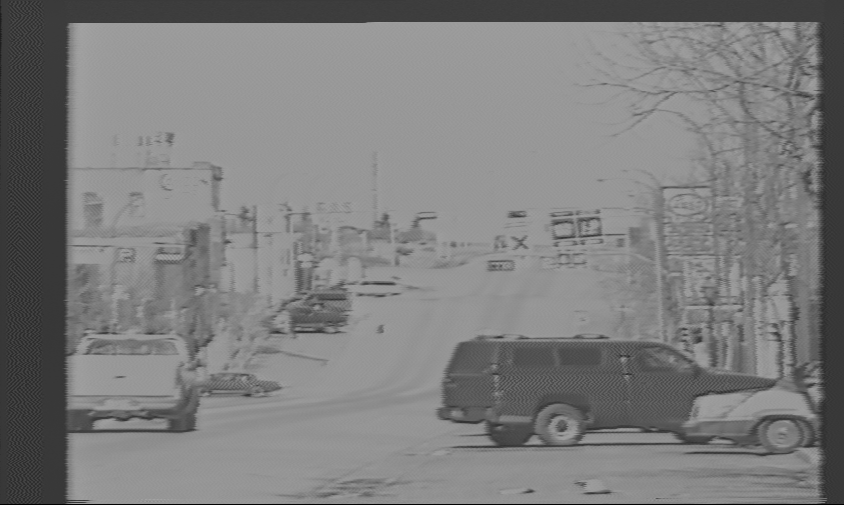

In [623]:
drawdata(frame, x=844, y=505)